# EQBSCQ: Experimental Quantum Battle of the Sexes: Classical & Quantum

## 1. Installation of libraries

Instalación de versiones compatibles

In [ ]:
!pip install -U -c https://qisk.it/1-0-constraints \
    qiskit==2.0.1 \
    qiskit-aer==0.17.0 \
    qiskit-ibm-runtime==0.39.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 4.5 MB/s eta 0:00:00


## 2. Imports and versions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, time
import qiskit, qiskit_aer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from collections import defaultdict
import networkx as nx

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.transpiler import Layout
from qiskit_aer import AerSimulator
from qiskit.result import marginal_counts

from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
)

from google.colab import files
import time
import pandas as pd
from tabulate import tabulate

print("== Librerías y versiones ==")
print(f" qiskit     : {qiskit.__version__}")
print(f" aer        : {qiskit_aer.__version__}")
print(f" numpy      : {np.__version__}")
print(f" matplotlib : {plt.matplotlib.__version__}\n")

== Librerías y versiones ==
 qiskit     : 2.0.1
 aer        : 0.17.0
 numpy      : 2.0.2
 matplotlib : 3.10.0



## 3. Connection to IBM Quantum Runtime

In [ ]:
# Save your token the first time (only if you haven't saved it yet):
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="adbc1ad77c763b810aacb9056bb91efe34839a4a75dcb9ba8236704dc630a6d2550eb0a590fb422858c0b2c0e8f1e96c078af0abcec7fdf4a0ef4b27ece278ab"  # <<<––– Token: CarlosD
)
service = QiskitRuntimeService(channel="ibm_quantum")  # It already reads the saved token

<ipython-input-4-c59e50ab1f63>:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")  # ya lee el token guardado


## 4. Classic game: Battle of the sexes

In [ ]:
classical = type(
    "ClassicalCoordinationGame", (), {
        "__init__": lambda self: setattr(
            self, "payoff",
            {(0,0):(3,2),(1,1):(2,3),(0,1):(0,0),(1,0):(0,0)}
        ),
        "mixed_equilibrium_payoffs": lambda self: (
            3*(3/5)*(2/5) + 2*((1-3/5)*(1-2/5)),
            2*(2/5)*(3/5) + 3*((1-2/5)*(1-3/5))
        )
    }
)()
EA_cl, EB_cl = classical.mixed_equilibrium_payoffs()

print(f"Pago esperado Alice: {EA_cl}")
print(f"Pago esperado Bob: {EB_cl}")

Pago esperado Alice: 1.2
Pago esperado Bob: 1.2


## 5. QuantumCoordGameRuntime Class

In [ ]:
class QuantumCoordGameRuntime:
    def __init__(self,
                 gamma=None,
                 shots=2048,
                 Strategy='I',
                 use_hardware=True,
                 use_multicrt=False,
                 Pairs=None,
                 Num_executions=None):
        self.shots = shots
        self.Strategy = Strategy
        self.use_multicrt = use_multicrt
        self.use_hardware = use_hardware
        self.qubits = []

        if use_multicrt:
            # Parameters for multi-circuit (lists of alpha/beta)
            self.Pairs = Pairs
            self.alpha, self.beta = [], []
            for g in np.linspace(0, np.pi, Num_executions):
                self.alpha.append(np.cos(g/2))
                self.beta.append(np.sin(g/2))
        else:
            # Simple entangled state
            self.alpha = np.cos(gamma/2)
            self.beta  = np.sin(gamma/2)

        # Backend selection
        if self.use_hardware:
            self.backend = service.least_busy(min_num_qubits=62, simulator=False)
            self.sampler = Sampler(mode=self.backend)
            self.sampler.options.default_shots = shots
        else:
            self.backend = AerSimulator()
            self.sampler = self.backend

    def _select_best_adjacent_qubits(self):
        if self.backend.coupling_map is None:
            return [0, 1]
        edges = self.backend.coupling_map.get_edges()
        cx_errors = {}
        for i, j in edges:
            props = self.backend.target.get("cx", {}).get((i, j), None)
            if props is not None:
                cx_errors[(i, j)] = props.error
        if not cx_errors:
            print("⚠️ No CX data found; defaulting to [0,1].") # ⚠️ No se encontraron datos de CX; usando [0,1] por defecto.
            return [0, 1]
        return list(min(cx_errors, key=cx_errors.get))

    def _build_circuit(self, gateA, gateB):
        if self.use_multicrt:
            qc = QuantumCircuit(len(self.Pairs)*2, len(self.Pairs)*2)
            for num, (q0, q1) in enumerate(self.Pairs):
                # 1) prepare entanglement in qubits [2*num, 2*num+1]
                qc.append(StatePreparation(
                    [self.alpha[num], 0, 0, self.beta[num]]),
                    [2*num, 2*num+1]
                )
                # 2) apply gates on that block
                for gate, offset in ((gateA, 0), (gateB, 1)):
                    target = 2*num + offset
                    if gate == 'H':      qc.h(target)
                    elif gate == 'R(pi_4)': qc.ry(np.pi/4, target)
                    elif gate == 'R(pi)':   qc.ry(np.pi, target)
                    # 'I' does nothing
                # 3) measure that pair
                qc.measure([2*num, 2*num+1], [2*num, 2*num+1])
        else:
            # single-pair
            self.qubits = self._select_best_adjacent_qubits()
            qc = QuantumCircuit(2, 2)
            qc.append(StatePreparation([self.alpha, 0, 0, self.beta]), [0, 1])
            for gate, idx in ((gateA, 0), (gateB, 1)):
                if gate == 'H':      qc.h(idx)
                elif gate == 'R(pi_4)': qc.ry(np.pi/4, idx)
                elif gate == 'R(pi)':   qc.ry(np.pi, idx)
            qc.measure([0, 1], [0, 1])

        return qc

    def _transpile(self, qc):
        if self.use_hardware and self.qubits:
            return transpile(
                qc,
                backend=self.backend,
                initial_layout=self.qubits,
                layout_method='sabre',
                routing_method='sabre',
                optimization_level=3
            )
        return transpile(qc, backend=self.backend)

    def analyze_entangled_pairs(self, result, circuit_index=0):
        all_counts = result[0].data.c.get_counts()
        analysis = {}
        for i, (q1, q2) in enumerate(self.Pairs):
            c1, c2 = 2*i, 2*i+1
            pair_counts = marginal_counts(all_counts, [c1, c2])
            counts = {'00':0,'01':0,'10':0,'11':0}
            counts.update(pair_counts)
            analysis[f'pair_{i}'] = {'qubits': (q1, q2), 'counts': counts}
        return analysis

    def payoffs(self):
        qc  = self._build_circuit(self.Strategy, self.Strategy)
        tqc = self._transpile(qc)

        if self.use_multicrt:
            job = self.sampler.run([tqc])
            res = job.result(timeout=1800)
            return self.analyze_entangled_pairs(res)

        # single-circuit
        if self.use_hardware:
            job = self.sampler.run([tqc])
            res = job.result(timeout=1800)
            counts = res[0].data.c.get_counts()
            total = sum(counts.values())
            p00 = counts.get('00',0)/total if total else 0
            p11 = counts.get('11',0)/total if total else 0
        else:
            res = self.sampler.run(tqc, shots=self.shots).result()
            counts = res.get_counts()
            p00 = counts.get('00',0)/self.shots
            p11 = counts.get('11',0)/self.shots

        EA  = 3*p00 + 2*p11
        EB  = 2*p00 + 3*p11
        Err = 1 - (p00 + p11)
        return EA, EB, Err

## 6. Architecture

In [ ]:
list_arq_127qb = [[0, 1], [3, 4], [6, 7], [9, 10], [12, 13], [18, 19], [21, 22],
 [24, 25], [27, 28], [30, 31], [37, 38], [40, 41], [43, 44], [46, 47], [49, 50],
  [56, 57], [59, 60], [62, 63], [65, 66], [68, 69], [75, 76], [78, 79], [81, 82],
   [84, 85], [87, 88], [94, 95], [97, 98], [100, 101], [103, 104], [106, 107],
    [113, 114], [116, 117], [119, 120], [122, 123], [125, 126]]

In [ ]:
list_par_qb = list_arq_127qb[:31]

## 7. Sweep γ in simulator

[✓] First image saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/Simulacion/0_Simulation_Payoff_strategy_R(pi).png


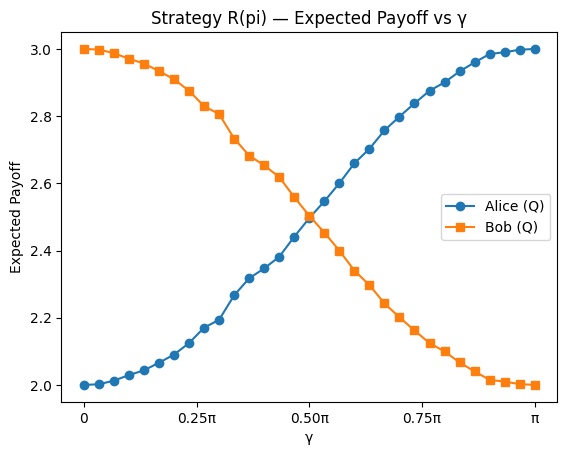

[✓] Second image saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/Simulacion/1_Simulation_Miscoordination_strategy_R(pi).png


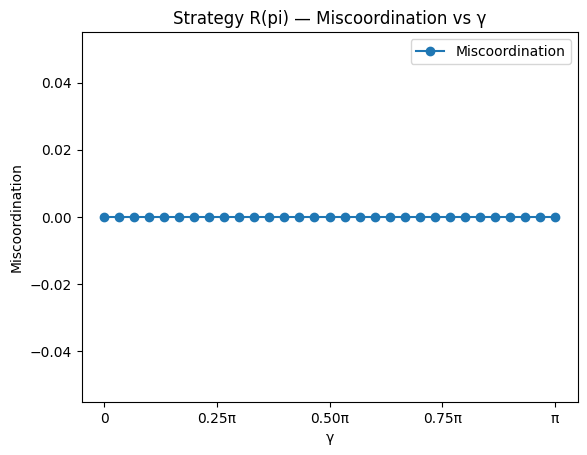

In [ ]:
# Only strategy 'H'
gammas = np.linspace(0, np.pi, 31)
strategy = 'R(pi)'

EA_qs, EB_qs, Err_qs = [], [], []

for g in gammas:
    game = QuantumCoordGameRuntime(
        gamma=g,
        shots=2048,
        Strategy=strategy,
        use_hardware=False,
        use_multicrt=False
    )
    EA, EB, Err = game.payoffs()
    EA_qs.append(EA)
    EB_qs.append(EB)
    Err_qs.append(Err)

# Function to format X-axis labels as multiples of π
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0): return "0"
    elif np.isclose(frac, 1): return "π"
    elif frac.is_integer(): return f"{int(frac)}π"
    else: return f"{frac:.2f}π"

# --- Plot: Expected Payoff vs γ ---
plt.figure()
plt.plot(gammas, EA_qs, '-o', label='Alice (Q)')
plt.plot(gammas, EB_qs, '-s', label='Bob (Q)')
plt.title(f'Strategy {strategy} — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend()

ax1 = plt.gca()
ax1.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax1.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path1 = "/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/Simulacion/0_Simulation_Payoff_strategy_R(pi).png"
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] First image saved at: {path1}")

plt.show()
plt.close()

# --- Plot: Miscoordination vs γ ---
plt.figure()
plt.plot(gammas, Err_qs, '-o', label='Miscoordination')
plt.title(f'Strategy {strategy} — Miscoordination vs γ')
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()
ax2 = plt.gca()
ax2.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax2.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path2 = "/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/Simulacion/1_Simulation_Miscoordination_strategy_R(pi).png"
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Second image saved at: {path2}")

plt.show()
plt.close()

## 8. Execution on real hardware

In [ ]:
def calcular_promedios_distribuidos(lista_datos, grupos=31):
    promedios = []
    for i in range(grupos):
        # Select elements of group i: i, i+31, i+62, etc.
        elementos_grupo = lista_datos[i::grupos]
        # Calculate the average of the group
        promedio = sum(elementos_grupo) / len(elementos_grupo)
        promedios.append(promedio)
    return promedios
def calcular_varianza_desviacion_distribuidos(lista_datos, promedio, grupos=31):
    varianza = []
    desviacion = []
    for i in range(grupos):
        # Select elements of group i: i, i+31, i+62, etc.
        elementos_grupo = lista_datos[i::grupos]
        # Calculate the variance of the group
        varianza_grupo = sum((x - promedio[i]) ** 2 for x in elementos_grupo) / (len(elementos_grupo) - 1)
        varianza.append(varianza_grupo)
        desviacion_grupo = varianza_grupo ** 0.5
        desviacion.append(desviacion_grupo)
    return varianza, desviacion

In [ ]:
P00.clear()
P01.clear()
P10.clear()
P11.clear()
times_real.clear()
list_par_qb_min_err.clear()
multicrt.clear()

In [ ]:
Intent = 5

In [ ]:
# Make sure to have enough time in IBM Quantum Approx 1 min 31 sec per execution
strategy = 'R(pi)' # Strategy choice (R(pi))
Num_exe = 31 # Number of executions
P00, P01, P10, P11 = [], [], [], [] # Lists where data will be saved
times_real = []
list_par_qb_min_err = []
for par_init in range(Num_exe):
    for i in range(par_init, par_init + len(list_par_qb)):
        list_par_qb_min_err.append(list_par_qb[i % len(list_par_qb)]) # Error minimization strategy per iteration
    start_real = time.time()
    multicrt = QuantumCoordGameRuntime( # Define the multiple quantum circuit
        shots=2048,
        use_hardware=True,
        use_multicrt=True,
        Pairs=list_par_qb_min_err,
        Num_executions=Num_exe,
        Strategy=strategy
    ).payoffs()
    elapsed = time.time() - start_real
    times_real.append(elapsed)
    for j in range(Num_exe): # Iterate over all pairs for each iteration for error minimization
            counts = multicrt[f'pair_{j}']['counts']
            P00.append(multicrt[f'pair_{j}']['counts'].get("00", 0) / 2048)
            P01.append(multicrt[f'pair_{j}']['counts'].get("01", 0) / 2048)
            P10.append(multicrt[f'pair_{j}']['counts'].get("10", 0) / 2048)
            P11.append(multicrt[f'pair_{j}']['counts'].get("11", 0) / 2048)
    list_par_qb_min_err.clear()

In [ ]:
# Calculation of average values
P00_prom = calcular_promedios_distribuidos(P00, grupos=Num_exe)
P01_prom = calcular_promedios_distribuidos(P01, grupos=Num_exe)
P10_prom = calcular_promedios_distribuidos(P10, grupos=Num_exe)
P11_prom = calcular_promedios_distribuidos(P11, grupos=Num_exe)
# Calculation of Variance and Standard Deviation
P00_var, P00_desv = calcular_varianza_desviacion_distribuidos(P00, P00_prom, grupos=Num_exe)
P01_var, P01_desv = calcular_varianza_desviacion_distribuidos(P01, P01_prom, grupos=Num_exe)
P10_var, P10_desv = calcular_varianza_desviacion_distribuidos(P10, P10_prom, grupos=Num_exe)
P11_var, P11_desv = calcular_varianza_desviacion_distribuidos(P11, P11_prom, grupos=Num_exe)

In [ ]:
EA_real, EB_real, Err_EA_real, Err_EB_real = [], [], [], []
Miscoord_real, Err_Miscoord_real = [], []
for i in range(Num_exe):
    # Calculation of real payoffs
    EA_real.append(P00_prom[i] * 3 + P11_prom[i] * 2)
    EB_real.append(P00_prom[i] * 2 + P11_prom[i] * 3)
    # Calculation of real error propagation
    Err_EA_real.append(np.sqrt((3 * P00_desv[i] / np.sqrt(Num_exe))**2 + (2 * P11_desv[i] / np.sqrt(Num_exe))**2))
    Err_EB_real.append(np.sqrt((2 * P00_desv[i] / np.sqrt(Num_exe))**2 + (3 * P11_desv[i] / np.sqrt(Num_exe))**2))
    # Calculation of miscoordination
    Miscoord_real.append(P01_prom[i] + P10_prom[i])
    # Calculation of error propagation
    Err_Miscoord_real.append(np.sqrt((P01_desv[i] / np.sqrt(Num_exe))**2 + (P10_desv[i] / np.sqrt(Num_exe))**2))

## 9. Result Graphs

[✓] Real payoff saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/5/Real/0_Real_Minimized_strategy_R(pi).png


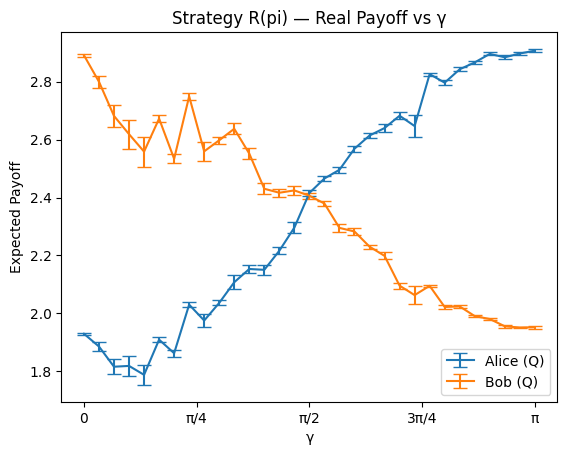

In [ ]:
# --- Figure 1: Real Payoff vs γ ---
fig3 = plt.figure()
plt.errorbar(gammas, EA_real, yerr=Err_EA_real, fmt='-', capsize=5, label='Alice (Q)')
plt.errorbar(gammas, EB_real, yerr=Err_EB_real, fmt='-', capsize=5, label='Bob (Q)')
plt.title("Strategy R(pi) — Real Payoff vs γ")
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend()

# Configurar eje X con múltiplos de π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # marcas cada π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_payoff = f"/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/{Intent}/Real/0_Real_Minimized_strategy_R(pi).png"
fig3.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved at: {path_payoff}")

plt.show()
plt.close(fig3)

[✓] Real miscoordination saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/5/Real/1_Real_Miscoordination_strategy_R(pi).png


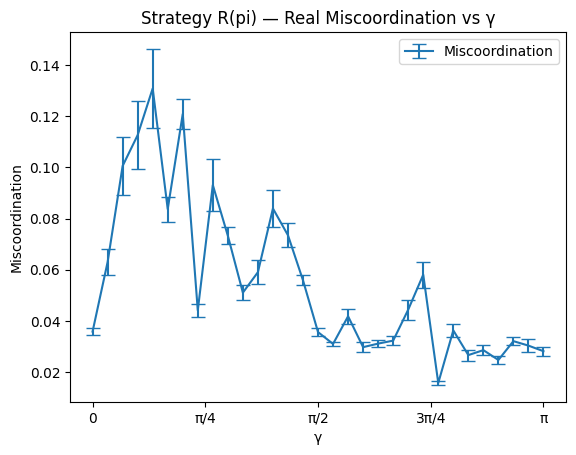

In [ ]:
# --- Figure 2: Real Miscoordination vs γ ---
fig4 = plt.figure()
plt.errorbar(gammas, Miscoord_real, yerr=Err_Miscoord_real, fmt='-', capsize=5, label='Miscoordination')
plt.title("Strategy R(pi) — Real Miscoordination vs γ")
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()

# Configurar eje X con múltiplos de π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # marcas cada π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_descoord = f"/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/{Intent}/Real/1_Real_Miscoordination_strategy_R(pi).png"
fig4.savefig(path_descoord, dpi=300, bbox_inches='tight')
print(f"[✓] Real miscoordination saved at: {path_descoord}")

plt.show()
plt.close(fig4)

[✓] Probability variance saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/5/Real/2_Probability_Variance_strategy_R(pi).png


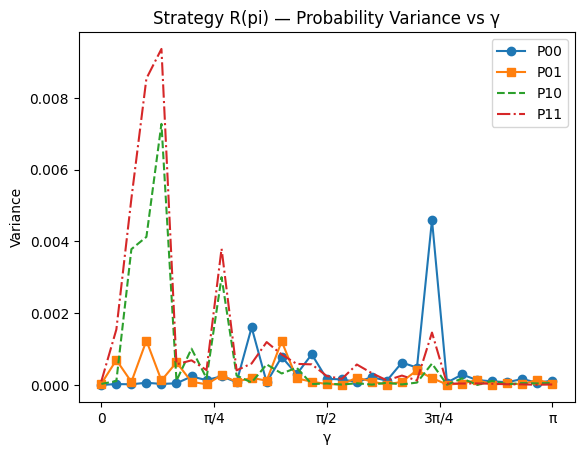

In [ ]:
# --- Figure 3: Probability Variance vs γ ---
fig5 = plt.figure()
plt.plot(gammas, P00_var, '-o', label='P00')
plt.plot(gammas, P01_var, '-s', label='P01')
plt.plot(gammas, P10_var, '--', label='P10')
plt.plot(gammas, P11_var, '-.', label='P11')
plt.title("Strategy R(pi) — Probability Variance vs γ")
plt.xlabel("γ")
plt.ylabel("Variance")
plt.legend()

# Configurar eje X con múltiplos de π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # marcas cada π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_var = f"/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/{Intent}/Real/2_Probability_Variance_strategy_R(pi).png"
fig5.savefig(path_var, dpi=300, bbox_inches='tight')
print(f"[✓] Probability variance saved at: {path_var}")

plt.show()
plt.close(fig5)

## 10. Comparison

In [ ]:
# Crear el DataFrame
df_comp = pd.DataFrame({
    'strategy':      [strategy] * Num_exe,
    'γ':             list(np.linspace(0, np.pi, Num_exe)),
    'EA_sim':        EA_qs[:Num_exe],
    'EA_real':       EA_real,
    'ΔEA':           [s - r for s, r in zip(EA_qs[:Num_exe], EA_real)],
    'Err_EA_real':   Err_EA_real,
    'EB_sim':        EB_qs[:Num_exe],
    'EB_real':       EB_real,
    'ΔEB':           [s - r for s, r in zip(EB_qs[:Num_exe], EB_real)],
    'Err_EB_real':   Err_EB_real,
    'Mis_sim':       Err_qs[:Num_exe],
    'Mis_real':      Miscoord_real,
    'ΔMis':          [s - r for s, r in zip(Err_qs[:Num_exe], Miscoord_real)],
    'Err_Mis_real':  Err_Miscoord_real,
    'Var_P00':       P00_var,
    'Var_P01':       P01_var,
    'Var_P10':       P10_var,
    'Var_P11':       P11_var,
    'Time_real_s':   times_real
})

# Ruta donde se guardará el archivo CSV
output_path = f'/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/{Intent}/CSV/tabla_strategy_R(pi).csv'

# Guardar el DataFrame como CSV
df_comp.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")
print(tabulate(df_comp, headers='keys', tablefmt='fancy_grid', showindex=False))

Archivo guardado en: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/5/CSV/tabla_strategy_R(pi).csv
╒════════════╤══════════╤══════════╤═══════════╤═══════════╤═══════════════╤══════════╤═══════════╤═══════════╤═══════════════╤═══════════╤════════════╤════════════╤════════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═══════════════╕
│ strategy   │        γ │   EA_sim │   EA_real │       ΔEA │   Err_EA_real │   EB_sim │   EB_real │       ΔEB │   Err_EB_real │   Mis_sim │   Mis_real │       ΔMis │   Err_Mis_real │     Var_P00 │     Var_P01 │     Var_P10 │     Var_P11 │   Time_real_s │
╞════════════╪══════════╪══════════╪═══════════╪═══════════╪═══════════════╪══════════╪═══════════╪═══════════╪═══════════════╪═══════════╪════════════╪════════════╪════════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═══════════════╡
│ R(pi)      │ 0        │  2       │   1.92914 │ 0.0708638 │    0.00361232 │  3       │   2.8917  │ 0.108304  │    0

## 11. Histogram of absolute errors

[✓] EA comparison chart saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/5/CSV/bar_EA_sim_vs_real_strategy_R(pi).png


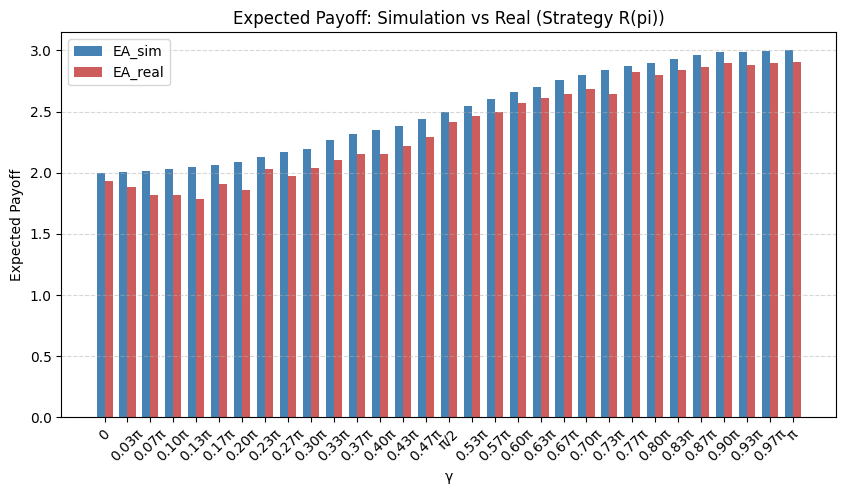

[✓] Miscoordination comparison chart saved at: /content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/5/CSV/bar_Mis_sim_vs_real_strategy_R(pi).png


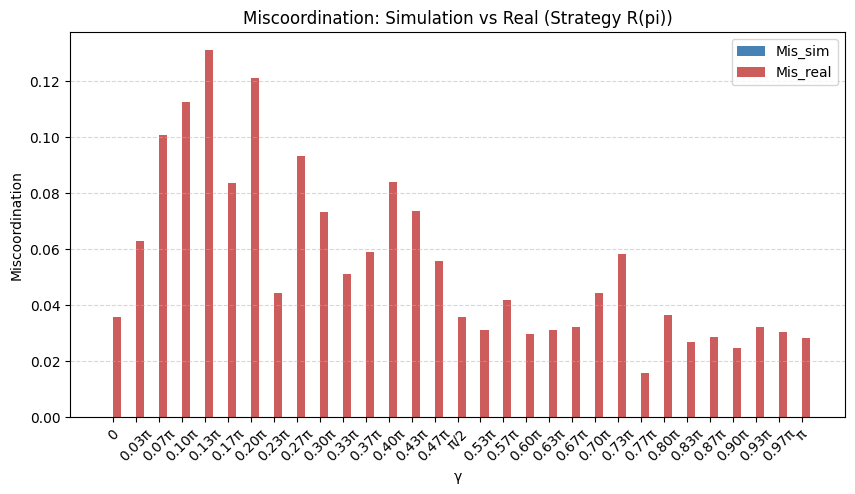

In [ ]:
gammas = df_comp['γ'].values
EA_sim = df_comp['EA_sim'].values
EA_real = df_comp['EA_real'].values
Mis_sim = df_comp['Mis_sim'].values
Mis_real = df_comp['Mis_real'].values

# Posiciones para las barras
indices = np.arange(len(gammas))
width   = 0.35

# Formatter de π
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0):      return "0"
    elif np.isclose(frac, 0.25): return "π/4"
    elif np.isclose(frac, 0.5):  return "π/2"
    elif np.isclose(frac, 0.75): return "3π/4"
    elif np.isclose(frac, 1.0):  return "π"
    else:                         return f"{frac:.2f}π"

# --- Gráfico de EA_sim vs EA_real ---
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(indices - width/2, EA_sim,  width, label='EA_sim', color='steelblue')
ax.bar(indices + width/2, EA_real, width, label='EA_real', color='indianred')

ax.set_title("Expected Payoff: Simulation vs Real (Strategy R(pi))")
ax.set_xlabel("γ")
ax.set_ylabel("Expected Payoff")
ax.set_xticks(indices)
ax.set_xticklabels([pi_formatter(g, None) for g in gammas], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

path1 = f"/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/{Intent}/CSV/bar_EA_sim_vs_real_strategy_R(pi).png"
os.makedirs(os.path.dirname(path1), exist_ok=True)
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] EA comparison chart saved at: {path1}")
plt.show()
plt.close()

# --- Gráfico de Mis_sim vs Mis_real ---
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(indices - width/2, Mis_sim,  width, label='Mis_sim', color='steelblue')
ax.bar(indices + width/2, Mis_real, width, label='Mis_real', color='indianred')

ax.set_title("Miscoordination: Simulation vs Real (Strategy R(pi))")
ax.set_xlabel("γ")
ax.set_ylabel("Miscoordination")
ax.set_xticks(indices)
ax.set_xticklabels([pi_formatter(g, None) for g in gammas], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

path2 = f"/content/drive/MyDrive/Works/Quantum/Code/Result/3_Strategie_R(pi)/{Intent}/CSV/bar_Mis_sim_vs_real_strategy_R(pi).png"
os.makedirs(os.path.dirname(path2), exist_ok=True)
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Miscoordination comparison chart saved at: {path2}")
plt.show()
plt.close()